In [1]:
import scanpy as sc
import torch
import lightning.pytorch as pl
from torch import nn
from torch.optim import AdamW
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPAutoEncoder
from self_supervision.estimator.cellnet import EstimatorAutoEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import pandas as pd

# 1. 加载数据集
data_dir = '../../dataset/Xenium_breast_cancer_sample1_replicate1.h5ad'
adata = sc.read_h5ad(data_dir)
#data preprocessing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)


# 2. 设置 checkpoint 路径
ckpt_path = "../../sc_pretrained/Pretrained Models/RandomMask.ckpt"

# 3. 模型参数
units_encoder = [512, 512, 256, 256, 64]
units_decoder = [256, 256, 512, 512]

# 初始化 EstimatorAutoEncoder 实例
estim = EstimatorAutoEncoder(data_path=None)  # 没有实际数据路径，可以设置为None

# 4. 加载预训练模型
estim.model = MLPAutoEncoder.load_from_checkpoint(
    ckpt_path,
    gene_dim=19331,  # 根据你的数据调整
    batch_size=128,  # 根据你的需要调整
    units_encoder=units_encoder, 
    units_decoder=units_decoder,
    masking_strategy="random",  # 假设模型使用了随机掩码
    masking_rate=0.5,  # 根据需要调整
)

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [2]:
# 添加分类层 (FC)
n_classes = len(adata.obs['cell_type'].unique())
estim.model.fc = nn.Linear(units_encoder[-1], n_classes)
n_classes

20

In [3]:
var_df = pd.read_parquet('../../sc_pretrained/var.parquet')
all_genes = var_df['feature_name'].tolist()

new_data = np.zeros((adata.X.shape[0], len(all_genes)), dtype=np.float32)

adata.var['gene_name']=adata.var.index
existing_genes = adata.var['gene_name']

In [4]:
# 将所有基因名称转换为小写
all_genes_lower = [gene.lower() for gene in all_genes]
adata_genes_lower = [gene.lower() for gene in existing_genes]

# 将两个列表转换为集合
all_genes_set = set(all_genes_lower)
adata_genes_set = set(adata_genes_lower)

# 计算交集
matching_genes = all_genes_set.intersection(adata_genes_set)
matching_count = len(matching_genes)
# 计算不匹配的基因
non_matching_genes = adata_genes_set - matching_genes
non_matching_count = len(non_matching_genes)


# 输出结果
print(f"匹配的基因数量: {matching_count}")
print(f"匹配的基因列表: {matching_genes}")
non_matching_genes

匹配的基因数量: 305
匹配的基因列表: {'tpsab1', 'rhoh', 'tmem147', 'cavin2', 'ncam1', 'scgb2a1', 'serpina3', 'krt8', 'cd163', 'oxtr', 's100a8', 'ahsp', 'dapk3', 'c1qc', 'ctla4', 'ms4a1', 'zeb2', 'c6orf132', 'klrf1', 'c2orf42', 'sox18', 'ceacam8', 'cd274', 'foxa1', 'fcer1a', 'ndufa4l2', 'prf1', 'sox17', 'eif4ebp1', 'tomm7', 'mmp2', 'cd3e', 'pdk4', 'mybpc1', 'ar', 'elf5', 'ccl20', 'cth', 'pcolce', 'top2a', 'pparg', 'ucp1', 'lag3', 'abcc11', 'sec24a', 'cd14', 'ccnd1', 'vwf', 'tacstd2', 'slamf1', 'klrb1', 'avpr1a', 'angpt2', 'adipoq', 'igsf6', 'tcf15', 's100a14', 'cd8a', 'tuba4a', 'klrd1', 'medag', 'adam9', 'igf1', 'c15orf48', 'cytip', 'lyz', 'esm1', 'itm2c', 'snai1', 'cd79a', 'mmrn2', 'cd4', 'clec14a', 'foxc2', 'dnaaf1', 'ccdc80', 'scd', 'mlph', 'glipr1', 'apobec3b', 'traf4', 'tcl1a', 'ccl8', 'ly86', 'srpk1', 'krt16', 'clecl1', 'cav1', 'ccr7', 'acta2', 'pdgfrb', 'aif1', 'il2ra', 'fgl2', 'fstl3', 'nkg7', 'lif', 'pclaf', 'ednrb', 'mzb1', 'tyrobp', 'cd27', 'fam107b', 'tent5c', 'cdh1', 'prdm1', 'erbb2', 'sf

{'fam49a', 'kars', 'lars', 'nars', 'polr2j3', 'qars', 'trac', 'wars'}

In [5]:
gene_to_index = {gene: idx for idx, gene in enumerate(all_genes_lower)}
dense_adata_X = adata.X.toarray()
for i, gene in enumerate(adata_genes_lower):
    if gene in gene_to_index:
        new_data[:, gene_to_index[gene]] = dense_adata_X[:, i]
    else:
        print(f'Gene {gene} not found in all_genes list')

Gene fam49a not found in all_genes list


Gene kars not found in all_genes list
Gene lars not found in all_genes list


Gene nars not found in all_genes list
Gene polr2j3 not found in all_genes list
Gene qars not found in all_genes list


Gene trac not found in all_genes list
Gene wars not found in all_genes list


In [6]:
# 使用 GPU 进行评估（如果可用）
estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)

# 5. 数据集划分（70% 训练，15% 验证，15% 测试）
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(adata.obs['cell_type'])  # 预先编码标签


random_seed = 42

X_train_val, X_test, y_train_val, y_test = train_test_split(
    new_data, labels_encoded, test_size=0.15, random_state=random_seed)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=random_seed)  # 0.1765 是为了让验证集占 15%

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


In [7]:
# 将训练数据转换为张量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_val_tensor = torch.tensor(X_val).float().to(device)
y_val_tensor = torch.tensor(y_val).long().to(device)
estim.model.to(device)

MLPAutoEncoder(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (encoder): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=256, b

In [8]:
# 6. 微调模型，仅微调 encoder 的最后两层，其他层参数冻结
for param in estim.model.encoder.parameters():
    param.requires_grad = False  # 冻结所有层

# 解冻最后两层
for param in list(estim.model.encoder.parameters())[-5:]:
    param.requires_grad = True

In [9]:
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, estim.model.parameters()), lr=9e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [10]:
from torch.utils.data import DataLoader, TensorDataset

# 设置 batch size
batch_size = 128  # 根据实际需求调整 batch size

# 使用 TensorDataset 将训练数据和标签打包
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 使用 DataLoader 来创建批次
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 7. 微调模型
def train_epoch(model, optimizer, loss_fn, train_loader, val_loader):
    model.train()
    total_train_loss = 0
    
    # 训练集批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model.encoder(X_batch)
        logits = model.fc(outputs)
        
        # 计算损失
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 验证集
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model.encoder(X_val_batch)
            val_logits = model.fc(val_outputs)
            val_loss = loss_fn(val_logits, y_val_batch)
            total_val_loss += val_loss.item()

    # 返回平均损失
    return total_train_loss / len(train_loader), total_val_loss / len(val_loader)

In [11]:
import copy  # 用于保存模型的最佳状态

# Early Stopping 参数
patience = 20  # 如果验证损失在 10 个 epoch 中没有改善，停止训练
min_delta = 1e-4  # 最小改善幅度
patience_counter = 0
best_val_loss = float('inf')  # 初始设置为正无穷大
best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存最佳模型权重
train_losses = []
val_losses = []

# 训练 500 个 epoch
for epoch in range(500):
    train_loss, val_loss = train_epoch(estim.model, optimizer, loss_fn, train_loader, val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early Stopping 检查
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss  # 更新最佳验证损失
        patience_counter = 0  # 重置 patience 计数器
        best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存当前最佳模型
        print(f"Validation loss improved to {best_val_loss}, resetting patience.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
    
    # 如果 patience_counter 超过设置的 patience，停止训练
    if patience_counter >= patience:
        print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
        break

# 恢复到训练中性能最好的模型权重
estim.model.load_state_dict(best_model_weights)
print("Loaded best model weights based on validation loss.")

Epoch 1, Train Loss: 0.8301682824143137, Validation Loss: 0.4401649365267778
Validation loss improved to 0.4401649365267778, resetting patience.


Epoch 2, Train Loss: 0.615151080528116, Validation Loss: 0.4343357839560146
Validation loss improved to 0.4343357839560146, resetting patience.


Epoch 3, Train Loss: 0.5924894351325524, Validation Loss: 0.4155467949845464
Validation loss improved to 0.4155467949845464, resetting patience.


Epoch 4, Train Loss: 0.5800473421876986, Validation Loss: 0.4317102664467042
No improvement in validation loss. Patience counter: 1/20


Epoch 5, Train Loss: 0.5721322461995164, Validation Loss: 0.430643153599071
No improvement in validation loss. Patience counter: 2/20


Epoch 6, Train Loss: 0.5682827490087687, Validation Loss: 0.4066115740289543
Validation loss improved to 0.4066115740289543, resetting patience.


Epoch 7, Train Loss: 0.5588891874016759, Validation Loss: 0.400841497830328
Validation loss improved to 0.400841497830328, resetting patience.


Epoch 8, Train Loss: 0.5574091608293176, Validation Loss: 0.3947078293652704
Validation loss improved to 0.3947078293652704, resetting patience.


Epoch 9, Train Loss: 0.5528543049668435, Validation Loss: 0.3951034393104805
No improvement in validation loss. Patience counter: 1/20


Epoch 10, Train Loss: 0.5482337990357725, Validation Loss: 0.384589918373805
Validation loss improved to 0.384589918373805, resetting patience.


Epoch 11, Train Loss: 0.5484195952192111, Validation Loss: 0.39609337927121196
No improvement in validation loss. Patience counter: 1/20


Epoch 12, Train Loss: 0.5467987875403402, Validation Loss: 0.3999669383171246
No improvement in validation loss. Patience counter: 2/20


Epoch 13, Train Loss: 0.5469098055739289, Validation Loss: 0.3754657134791921
Validation loss improved to 0.3754657134791921, resetting patience.


Epoch 14, Train Loss: 0.5396684747440883, Validation Loss: 0.38239100976341267
No improvement in validation loss. Patience counter: 1/20


Epoch 15, Train Loss: 0.5388200539843968, Validation Loss: 0.393125608714704
No improvement in validation loss. Patience counter: 2/20


Epoch 16, Train Loss: 0.5341588998282397, Validation Loss: 0.39169640090259805
No improvement in validation loss. Patience counter: 3/20


Epoch 17, Train Loss: 0.5329345424775205, Validation Loss: 0.3767591591565137
No improvement in validation loss. Patience counter: 4/20


Epoch 18, Train Loss: 0.5352538539693247, Validation Loss: 0.3836465712428698
No improvement in validation loss. Patience counter: 5/20


Epoch 19, Train Loss: 0.5264591301643251, Validation Loss: 0.37214896022365784
Validation loss improved to 0.37214896022365784, resetting patience.


Epoch 20, Train Loss: 0.5274244144331656, Validation Loss: 0.37333179745577316
No improvement in validation loss. Patience counter: 1/20


Epoch 21, Train Loss: 0.5246403207576352, Validation Loss: 0.3652341800746579
Validation loss improved to 0.3652341800746579, resetting patience.


Epoch 22, Train Loss: 0.5283418257836423, Validation Loss: 0.3689311714039236
No improvement in validation loss. Patience counter: 1/20


Epoch 23, Train Loss: 0.5239206073655542, Validation Loss: 0.36724081885088516
No improvement in validation loss. Patience counter: 2/20


Epoch 24, Train Loss: 0.5269313087130943, Validation Loss: 0.3655823823159116
No improvement in validation loss. Patience counter: 3/20


Epoch 25, Train Loss: 0.5243770048054734, Validation Loss: 0.37820239145743667
No improvement in validation loss. Patience counter: 4/20


Epoch 26, Train Loss: 0.5200932385615015, Validation Loss: 0.3777857220868774
No improvement in validation loss. Patience counter: 5/20


Epoch 27, Train Loss: 0.5223252360986989, Validation Loss: 0.3650831391061018
Validation loss improved to 0.3650831391061018, resetting patience.


Epoch 28, Train Loss: 0.5199046235263737, Validation Loss: 0.3677218073818284
No improvement in validation loss. Patience counter: 1/20


Epoch 29, Train Loss: 0.5197169618733828, Validation Loss: 0.36474104997167733
Validation loss improved to 0.36474104997167733, resetting patience.


Epoch 30, Train Loss: 0.5194276373240942, Validation Loss: 0.3808981139345217
No improvement in validation loss. Patience counter: 1/20


Epoch 31, Train Loss: 0.517687030282675, Validation Loss: 0.35396298607291304
Validation loss improved to 0.35396298607291304, resetting patience.


Epoch 32, Train Loss: 0.5157793037642061, Validation Loss: 0.3629508745398013
No improvement in validation loss. Patience counter: 1/20


Epoch 33, Train Loss: 0.514645799053001, Validation Loss: 0.3634618209098196
No improvement in validation loss. Patience counter: 2/20


Epoch 34, Train Loss: 0.5149581724197516, Validation Loss: 0.38070108109924394
No improvement in validation loss. Patience counter: 3/20


Epoch 35, Train Loss: 0.5142024960003647, Validation Loss: 0.36059865196646773
No improvement in validation loss. Patience counter: 4/20


Epoch 36, Train Loss: 0.5169948832596569, Validation Loss: 0.35966417760715874
No improvement in validation loss. Patience counter: 5/20


Epoch 37, Train Loss: 0.5150073690092382, Validation Loss: 0.35647728018046637
No improvement in validation loss. Patience counter: 6/20


Epoch 38, Train Loss: 0.5146718774810596, Validation Loss: 0.35971431668639786
No improvement in validation loss. Patience counter: 7/20


Epoch 39, Train Loss: 0.5123390584599739, Validation Loss: 0.3623990649499264
No improvement in validation loss. Patience counter: 8/20


Epoch 40, Train Loss: 0.513304086909315, Validation Loss: 0.3615226853771258
No improvement in validation loss. Patience counter: 9/20


Epoch 41, Train Loss: 0.5128142617496789, Validation Loss: 0.37099179557434797
No improvement in validation loss. Patience counter: 10/20


Epoch 42, Train Loss: 0.5102098256284635, Validation Loss: 0.3697332012169252
No improvement in validation loss. Patience counter: 11/20


Epoch 43, Train Loss: 0.5144238659304471, Validation Loss: 0.3597480899035023
No improvement in validation loss. Patience counter: 12/20


Epoch 44, Train Loss: 0.5095207992137647, Validation Loss: 0.3788423571489789
No improvement in validation loss. Patience counter: 13/20


Epoch 45, Train Loss: 0.5098233145046858, Validation Loss: 0.36669334406174986
No improvement in validation loss. Patience counter: 14/20


Epoch 46, Train Loss: 0.5124517174717648, Validation Loss: 0.3687897711840983
No improvement in validation loss. Patience counter: 15/20


Epoch 47, Train Loss: 0.5114346446879289, Validation Loss: 0.36546049149810966
No improvement in validation loss. Patience counter: 16/20


Epoch 48, Train Loss: 0.5086540024979183, Validation Loss: 0.37100278582367197
No improvement in validation loss. Patience counter: 17/20


Epoch 49, Train Loss: 0.5126264941978039, Validation Loss: 0.38110879948599086
No improvement in validation loss. Patience counter: 18/20


Epoch 50, Train Loss: 0.5097795601504042, Validation Loss: 0.36529902455770424
No improvement in validation loss. Patience counter: 19/20


Epoch 51, Train Loss: 0.5073908234993098, Validation Loss: 0.358725904132509
No improvement in validation loss. Patience counter: 20/20
Early stopping triggered. Stopping training at epoch 51.
Loaded best model weights based on validation loss.


In [12]:
import os

# 定义保存路径
save_dir = './xenium_best_model_ckpt'
save_path = os.path.join(save_dir, f'RM_FT_Xenium_breast_cancer_sample1_replicate1_best_model_{random_seed}.ckpt')

# 如果目录不存在，则创建
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 保存模型
torch.save(best_model_weights, save_path)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


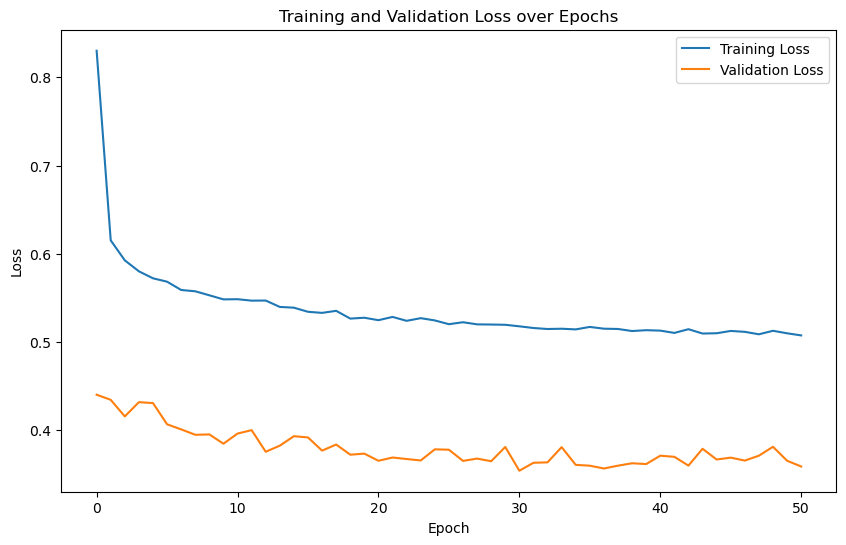

In [13]:
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot，而不是 matplotlib

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig(f'../loss_curve_fig/xenium_breast_cancer_random_mask_finetune_full_loss_curve{random_seed}.png', dpi=400)  # 保存图像为png格式，400 dpi
plt.savefig(f'../loss_curve_fig/xenium_breast_cancer_random_mask_finetune_full_loss_curve{random_seed}.eps', format='eps', dpi=400)  # 保存图像为png格式，400 dpi

plt.show()

In [14]:
import os

# 定义保存路径
save_dir = './xenium_best_model_ckpt'
save_path = os.path.join(save_dir, f'RM_FT_Xenium_breast_cancer_sample1_replicate1_best_model_{random_seed}.ckpt')

# 如果目录不存在，则创建
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 保存模型
torch.save(best_model_weights, save_path)

In [15]:
# 8. 使用 KNN 替代测试阶段的 FC 分类层
# 使用 encoder 提取训练集和测试集的 embedding
estim.model.eval()
with torch.no_grad():
    train_embeddings = estim.model.encoder(torch.tensor(X_train).float().to(device)).cpu().numpy()
    test_embeddings = estim.model.encoder(torch.tensor(X_test).float().to(device)).cpu().numpy()

In [16]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

    

    # 初始化和训练KNN分类器
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, y_train)
    
    # 模型预测
predictions = knn.predict(test_embeddings)

    # 计算准确率和 F1 分数
accuracy = accuracy_score(y_test, predictions)
print(f"KNN Accuracy on Test Data: {accuracy}")
f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score: {f1}")
    
macro_f1 = f1_score(y_test, predictions, average='macro')
print(f'Macro F1 Score: {macro_f1}')

    # 计算随机猜测的准确率
class_probabilities = np.bincount(y_test) / len(y_test)
random_accuracy = np.sum(class_probabilities ** 2)
print(f"Random Guess Accuracy: {random_accuracy}")

    # 生成分类报告
report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
print(report)

KNN Accuracy on Test Data: 0.8725314896491437
Weighted F1 Score: 0.8701440370433985
Macro F1 Score: 0.7762927268733703
Random Guess Accuracy: 0.1320247177116093
                         precision    recall  f1-score   support

                B_Cells       0.85      0.91      0.88       772
           CD4+_T_Cells       0.74      0.82      0.78      1286
           CD8+_T_Cells       0.75      0.72      0.73      1026
                 DCIS_1       0.86      0.91      0.88      1937
                 DCIS_2       0.82      0.81      0.81      1746
            Endothelial       0.92      0.93      0.93      1348
              IRF7+_DCs       0.96      0.91      0.93        74
         Invasive_Tumor       0.94      0.93      0.94      5230
             LAMP3+_DCs       0.83      0.80      0.81        49
          Macrophages_1       0.85      0.87      0.86      1692
          Macrophages_2       0.68      0.67      0.68       223
             Mast_Cells       0.80      0.86      0.83    

In [17]:
with torch.no_grad():
    new_data_tensor = torch.tensor(new_data).float().to(device)
    SSL_embeddings = estim.model.encoder(new_data_tensor).detach().cpu().numpy()
new_adata = sc.read_h5ad(data_dir)
new_adata.obsm[f'SSL_RM_FT_{random_seed}'] = SSL_embeddings
new_adata.uns[f'RM_FT_y_test_{random_seed}'] = y_test
new_adata.uns[f'RM_FT_predictions_{random_seed}'] = predictions
new_adata.uns[f'RM_FT_target_names_{random_seed}'] = label_encoder.classes_
new_adata.uns[f'RM_FT_train_loss_{random_seed}'] = train_losses
new_adata.uns[f'RM_FT_val_loss_{random_seed}'] = val_losses
new_adata.write_h5ad(data_dir)

In [18]:

import pandas as pd
import os
import re

# 当前 Notebook 文件名
notebook_name = "Xenium_breast_cancer_sample1_replicate1_random_mask_fine_tune_42.ipynb"

# 初始化需要打印的值
init_train_loss = train_losses[0] if 'train_losses' in globals() else None
init_val_loss = val_losses[0] if 'val_losses' in globals() else None
converged_epoch = len(train_losses) - patience if 'train_losses' in globals() else None
converged_val_loss = best_val_loss if 'best_val_loss' in globals() else None

# 打印所有所需的指标
print("Metrics Summary:")
if 'train_losses' in globals():
    print(f"init_train_loss\tinit_val_loss\tconverged_epoch\tconverged_val_loss\tmacro_f1\tweighted_f1\tmicor_f1")
    print(f"{init_train_loss:.3f}\t{init_val_loss:.3f}\t{converged_epoch}\t{converged_val_loss:.3f}\t{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")
else:
    print(f"macro_f1\tweighted_f1\tmicor_f1")
    print(f"{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")

# 保存结果到 CSV 文件
output_data = {
    'dataset_split_random_seed': [int(random_seed)],
    'dataset': ['xenium_breast_cancer_sample1_replicate1'],
    'method': [re.search(r'replicate1_(.*?)_\d+', notebook_name).group(1)],
    'init_train_loss': [init_train_loss if init_train_loss is not None else ''],
    'init_val_loss': [init_val_loss if init_val_loss is not None else ''],
    'converged_epoch': [converged_epoch if converged_epoch is not None else ''],
    'converged_val_loss': [converged_val_loss if converged_val_loss is not None else ''],
    'macro_f1': [macro_f1],
    'weighted_f1': [f1],
    'micor_f1': [accuracy]
}
output_df = pd.DataFrame(output_data)

# 保存到当前目录下名为 results 的文件夹中
if not os.path.exists('results'):
    os.makedirs('results')

csv_filename = f"results/{os.path.splitext(notebook_name)[0]}_results.csv"
output_df.to_csv(csv_filename, index=False)


Metrics Summary:
init_train_loss	init_val_loss	converged_epoch	converged_val_loss	macro_f1	weighted_f1	micor_f1
0.830	0.440	31	0.354	0.776	0.870	0.873
